In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_utils import BasicFunctions, PriceFunctions
from TechnicalAnalysis import TechnicalAnalysis 
from BackTest import Backtester, strategyBacktest
import math
import tensorflow as tf
from scipy.stats import linregress

from IPython.display import HTML

import os
from datetime import datetime

%matplotlib inline
%load_ext autoreload
%autoreload 2

c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
bf = BasicFunctions()
pf = PriceFunctions()

In [3]:
coins = ['BTC', 'ETH', 'DASH', 'DOGE', 'LTC', 'STR', 'XMR', 'XRP']

In [20]:
dfs = {}
merged_dfs = {}

pd_Xtrains = {}
pd_ytrains = {}
pd_Xtests = {}
pd_ytests = {}

pd_Xtrains_nd = {}
pd_Xtests_nd = {}

means = {}
stds = {}

Xtrains = {}
ytrains = {}
Xtests = {}
ytests = {}


for coin in coins:
    dfs[coin] = pf.get_pandas(coin=coin, targetdays=24, absolute=True)

dfs = pf.to_same_starting(dfs)
dfs = pf.to_usd(dfs)

for coin in coins:
    ta = TechnicalAnalysis(dfs[coin], Timeframe=[24], period=[14], coin=coin)
    ta.merge_time(cache=True)

    merged_dfs[coin] = ta.get_dic()['24hour']
    

for coin in coins:
    pd_Xtrains[coin], pd_ytrains[coin], pd_Xtests[coin], pd_ytests[coin] = pf.split_traintest(merged_dfs[coin])

    pd_Xtrains_nd[coin] = pd_Xtrains[coin].drop('Date', axis=1)
    pd_Xtests_nd[coin] = pd_Xtests[coin].drop('Date', axis=1)

    means[coin], stds[coin], Xtrains[coin], ytrains[coin], Xtests[coin], ytests[coin] = pf.get_numpy(pd_Xtrains_nd[coin], pd_ytrains[coin], pd_Xtests_nd[coin], pd_ytests[coin])

Read from cache
Read from cache
Read from cache
Read from cache
Read from cache
Read from cache
Read from cache
Read from cache


In [13]:
# ta = TechnicalAnalysis(df, timeframe=[3,6,12,24], period=[14, 20])
# ta.merge_time()

# ta.perform('obv')
# ta.perform('macd')
# ta.perform('bollingerband')
# ta.perform('volumechange')
# ta.perform('rsi')


# df_withta = ta.get_dataframe()
#gotta cache this too

In [14]:
def create_placeholders(Xshape, yshape):
    X = tf.placeholder(tf.float32, shape=(None, Xshape), name='X')
    y = tf.placeholder(tf.float32, shape=(None, yshape), name='y')
    
    return X,y

In [15]:
def forward_propagation(X, training):
    Z1 = tf.layers.dense(X, 30, name='Z1', kernel_initializer=tf.keras.initializers.he_normal(seed=1))
    bn1 = tf.layers.batch_normalization(Z1, training=training, name='bn1')
    ac1 = tf.nn.relu(bn1, name='ac1')
    A1 = tf.layers.dropout(ac1, 0.3, name='A1')
    
    Z2 = tf.layers.dense(A1, 15, name='Z2', kernel_initializer=tf.keras.initializers.he_normal(seed=1))
    bn2 = tf.layers.batch_normalization(Z2, training=training, name='bn2')
    ac2 = tf.nn.relu(bn2, name='ac2')
    A2 = tf.layers.dropout(ac2, 0.3, name='A2')
    
    Z3 = tf.layers.dense(A2, 2, name='Z3', kernel_initializer=tf.keras.initializers.he_normal(seed=1))
    #A3 = tf.nn.relu(Z3)

    return Z3

In [16]:
def cost_function(AL, y):
    classcost = tf.reduce_mean(tf.square(y[:, 0] - AL[:, 0]))
    percost = tf.reduce_mean(tf.square(y[:, 1] - AL[:, 1]))
    
    classification  = tf.abs(tf.log(classcost))
    regression = tf.abs(tf.log(percost))
    
    cost = 0.5 * classification + 5 * regression
    
    costs = [cost, classification, regression]
    
    return costs

In [48]:
def neuralNetwork(Xtrain, ytrain, Xtest, ytest, coin, batchsize=32):
    cwd = os.getcwd()

    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    logdir = "{}/run-{}/".format(root_logdir, now)
    
    tf.reset_default_graph()

    with tf.name_scope('Initialize'):
        X, y = create_placeholders(Xtrain.shape[1], 2)
        training = tf.placeholder(tf.bool, shape=(), name='training')

    with tf.name_scope('ForwardPropagation'):
        ALtensor = forward_propagation(X, training)

    with tf.name_scope('CostFunction'):
        cost = cost_function(ALtensor, ytrain)

    with tf.name_scope('BackPropagation'):
        optimizer = tf.train.AdamOptimizer(learning_rate=0.005).minimize(cost[0])

    init = tf.global_variables_initializer()

    cost_summary = tf.summary.scalar('Cost', cost[0])
    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    costs = []

    with tf.Session() as sess:
        sess.run(init)
        mini_batches = bf.initialize_mini_batch(Xtrain, ytrain, batchsize=batchsize)

        for i in range(1000):
            for batch in mini_batches:
                (Xbatch, ybatch) = batch
                sess.run(optimizer, feed_dict={X: Xbatch, y: ybatch, training: True})

            if (i % 50 == 0):
                cost_str = cost_summary.eval(feed_dict={X: Xbatch, y: ybatch, training: True})

                cost0 = cost[0].eval(feed_dict={X: Xbatch, y: ybatch, training: True})
                cost1 = cost[1].eval(feed_dict={X: Xbatch, y: ybatch, training: True})
                cost2 = cost[2].eval(feed_dict={X: Xbatch, y: ybatch, training: True})

                costs.append(cost0)

                print("Iteration: {}\nClassification cost: {}\nRegression cost: {}\nTotal Clost: {}\n\n".format(i, cost0, cost1, cost2))

                file_writer.add_summary(cost_str, i)


        saver = tf.train.Saver()
        
        sessiondir = cwd + '/tf_logs/session/session-{}.chkp'.format(coin)

        saver.save(sess, sessiondir)
        file_writer.close()

    bf.single_plot(costs, log=False)
    
    return sessiondir, X, ALtensor, training

Iteration: 0
Classification cost: 0.903347373008728
Regression cost: 0.06962472945451736
Total Clost: 0.1737069934606552


Iteration: 50
Classification cost: 0.09636422246694565
Regression cost: 0.016976045444607735
Total Clost: 0.01757523976266384


Iteration: 100
Classification cost: 0.0857541412115097
Regression cost: 0.0020703088957816362
Total Clost: 0.0169437974691391


Iteration: 150
Classification cost: 0.05529819801449776
Regression cost: 0.012593437917530537
Total Clost: 0.00980029534548521


Iteration: 200
Classification cost: 0.06670764833688736
Regression cost: 0.0014572623185813427
Total Clost: 0.013195804320275784


Iteration: 250
Classification cost: 0.14764542877674103
Regression cost: 0.0017640519654378295
Total Clost: 0.02935267984867096


Iteration: 300
Classification cost: 0.04213276505470276
Regression cost: 0.02009895257651806
Total Clost: 0.0064166574738919735


Iteration: 350
Classification cost: 0.06856793910264969
Regression cost: 0.01690583862364292
Total Cl

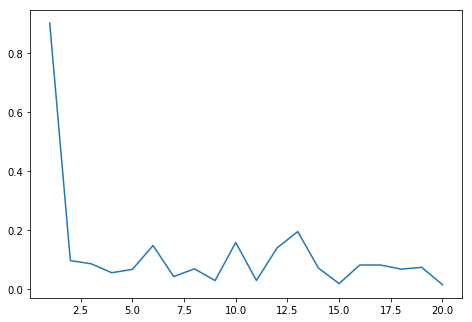

In [49]:
sessiondir, Xtensor, ALtensor, training = neuralNetwork(Xtrains['BTC'], ytrains['BTC'], Xtests['BTC'], ytests['BTC'], 'BTC')

In [52]:
def sigmoid(Z):
    return (1/(1+np.exp(-Z)))

def calculate_accuracy(AL, y):
    #calculate accuracy, precision, recall and F1 value here too
    ALc = AL[:, 0]
    yc = y[:, 0]
    
    ALc = ALc > 0.5
    ALc = ALc.astype(int)
    
    total = ALc.shape[0]
    
    TP = np.sum(np.logical_and(ALc==1, yc==1))
    TN = np.sum(np.logical_and(ALc==0, yc==0))
    
    FP = np.sum(np.logical_and(ALc==1, yc==0))
    FN = np.sum(np.logical_and(ALc==0, yc==1))
    
    P = TP / (TP + FP)
    R = TP / (TP + TN)
    F1 = (2 * P * R) / (P + R)
    
    
    acc = np.sum(ALc == yc)/total
    
    
    print("\nAccuracy: {} \n".format(acc))
    print("True Positive: {} \nTrue Negative: {}\nFalse Positive: {} \nFalse Negative: {}\n".format(TP, TN, FP, FN))
    print("Precision: {} \nRecall: {} \nF1 Score: {}\n".format(P, R, F1))
    
    
    ALcr = AL[:, 1]
    ycr = y[:, 1]

    fig, axes = plt.subplots(figsize=(12,6))
    axes.plot(ALcr, label="Predicted Value")
    axes.plot(ycr, label="Actual Value")
    axes.set_ylabel("Percentage Change")
    axes.set_title("Regression Comparision")
    axes.legend(loc=4)
    
    slope, intercept, rval, pval, stderr = linregress(ycr, ALcr)
    print("R-Value: " + str(rval)) #rvalue is between -1 and 1 and can be used for single. Suitable for my purpose. R2 can be used for multiple, gives one and zero
    
    maximum = max(ycr.max(),AL.max())
    minimum = min(ycr.min(),ALcr.min())
    fig2, ax2 = plt.subplots(figsize=(12,6))
    ax2.scatter(ycr,ALcr)
    ax2.plot([minimum, maximum], [minimum, maximum], 'r-', lw=2)
    
    return AL

In [59]:
def calc_metrics(Xval, yval, Xtensor, ALtensor, training, sessiondir):
    
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, sessiondir)

        Z = sess.run(ALtensor, feed_dict={Xtensor: Xval, training: False})
        Z[:, 0] = sigmoid(Z[:, 0])

        AL = calculate_accuracy(Z, yval)
        
    return AL

INFO:tensorflow:Restoring parameters from C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor/tf_logs/session/session-BTC.chkp

Accuracy: 0.49744245524296676 

True Positive: 300 
True Negative: 89
False Positive: 246 
False Negative: 147

Precision: 0.5494505494505495 
Recall: 0.7712082262210797 
F1 Score: 0.6417112299465241

R-Value: 0.08970169398206403


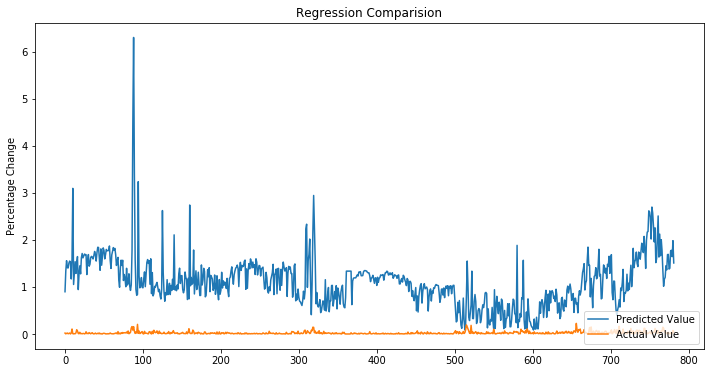

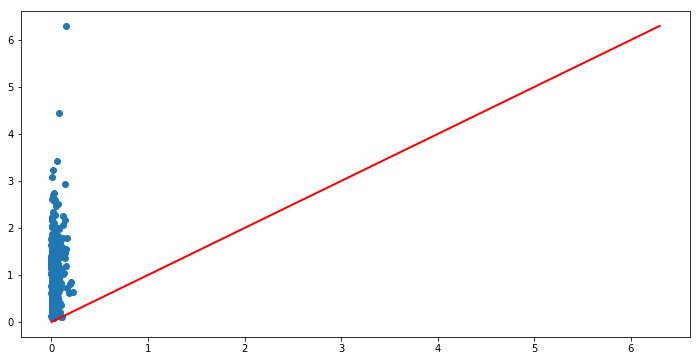

In [60]:
ALtrain = calc_metrics(Xtrains['BTC'], ytrains['BTC'], Xtensor, ALtensor, training, sessiondir)

INFO:tensorflow:Restoring parameters from C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor/tf_logs/session/session-BTC.chkp

Accuracy: 0.40993788819875776 

True Positive: 1 
True Negative: 65
False Positive: 0 
False Negative: 95

Precision: 1.0 
Recall: 0.015151515151515152 
F1 Score: 0.02985074626865672

R-Value: 0.1178008672785775


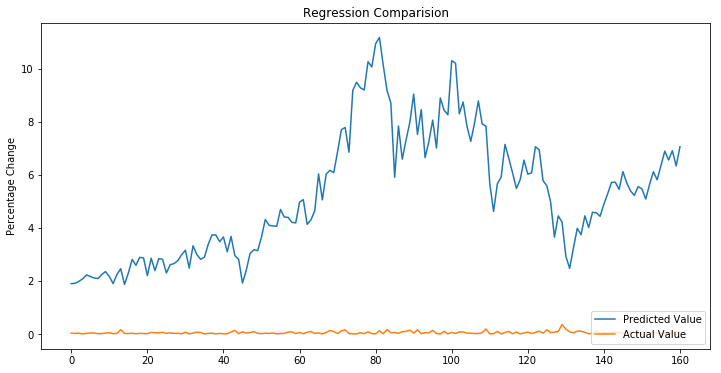

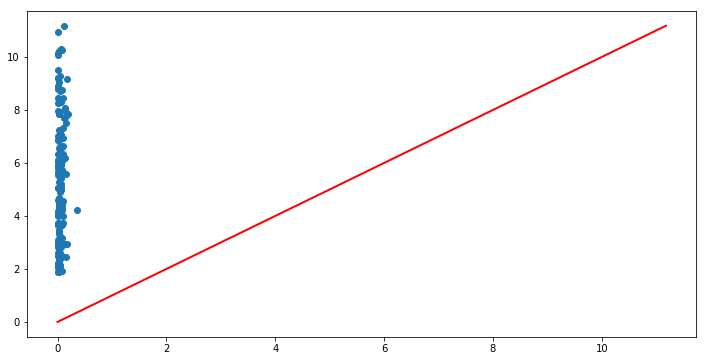

In [61]:
ALtest = calc_metrics(Xtests['BTC'], ytests['BTC'], Xtensor, ALtensor, training, sessiondir)

In [58]:
def perform_backtest(pd_Xtrain, pd_ytrain, AL, coin):
    pd_ytrain_mod = pd_ytrain.reset_index(drop=True)
    combined = pd.concat([pd_Xtrain, pd_ytrain_mod], axis=1)
    
    bars = {}
    bars[coin] = combined

    signals = {}
    signals[coin] = AL
    
    bt = Backtester(bars, signals, comission=0.1, maxper=0.01) #bars should contain 
    bt.perform_backtest()
    positions = bt.get_positions()
    bt.get_outcome()

C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor\BackTest\backtester.py:225: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  requiredcoins = closingsignals[self.positions['Coin'] == coin]
C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor\BackTest\backtester.py:227: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if(closingsignals[self.positions['Coin'] == coin].shape[0] != 0): #this also happens automatically with the other warning


Portfolio Stats:
Total Return: 63.68%
Sharpe Ratio: 0.687 Calmar Ratio: 0.007 Sortino Ratio: 0.896 Maximum Drawdown: -15.22%

BTC Portfolio:
Total Return: 1530.2%
Sharpe Ratio: 2.187 Calmar Ratio: 0.021 Sortino Ratio: 2.678 Maximum Drawdown: -20.1%


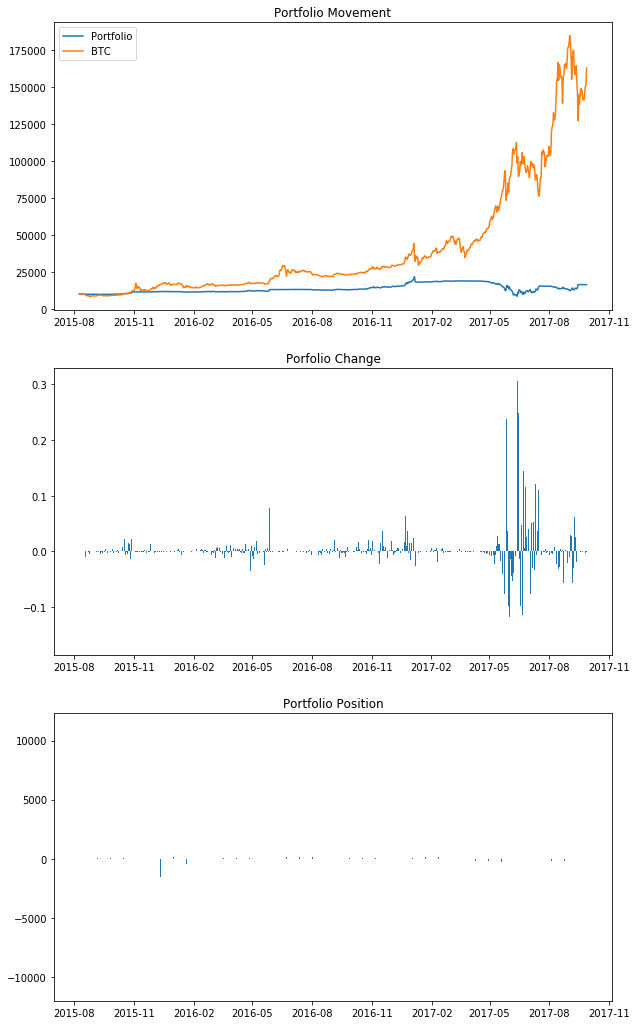

In [62]:
perform_backtest(pd_Xtrains['BTC'], pd_ytrains['BTC'], ALtrain, 'BTC')

C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor\BackTest\backtester.py:225: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  requiredcoins = closingsignals[self.positions['Coin'] == coin]
C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor\BackTest\backtester.py:227: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if(closingsignals[self.positions['Coin'] == coin].shape[0] != 0): #this also happens automatically with the other warning


Portfolio Stats:
Total Return: -4.94%
Sharpe Ratio: 0.33 Calmar Ratio: 0.002 Sortino Ratio: 0.519 Maximum Drawdown: -34.54%

BTC Portfolio:
Total Return: 157.89%
Sharpe Ratio: 2.344 Calmar Ratio: -inf Sortino Ratio: 3.389 Maximum Drawdown: 0.0%


C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor\BackTest\calculations.py:53: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = (np.average(percentage)/drawDown)


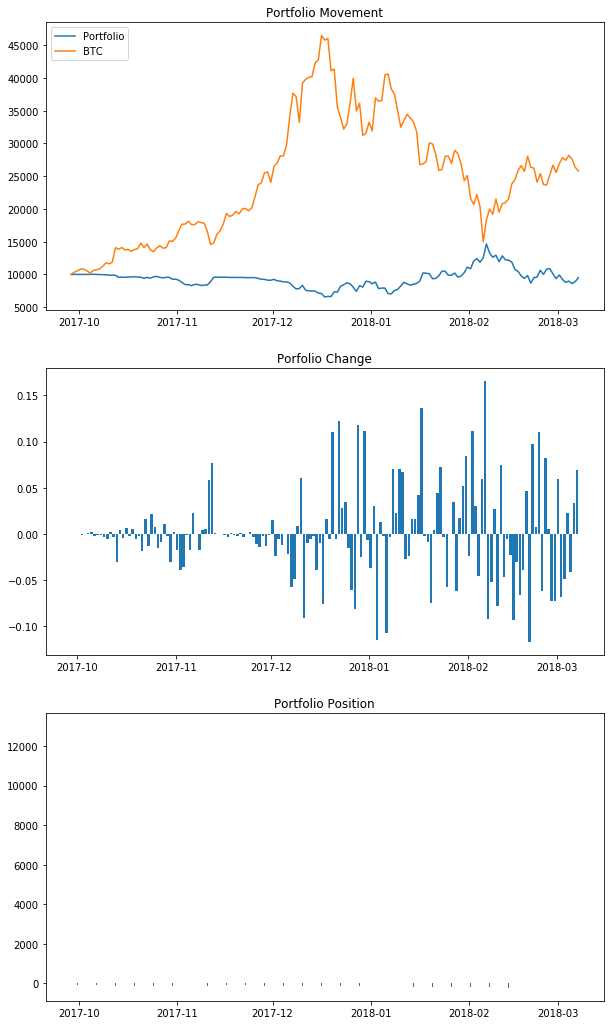

In [63]:
perform_backtest(pd_Xtests['BTC'], pd_ytests['BTC'], ALtest, 'BTC')